In [9]:

! pip install kaggle

In [10]:

! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:

! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [12]:

! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [13]:

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:

! unzip /content/brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [15]:
import os

def count_images_in_classes(directory):
    classes = os.listdir(directory)
    class_image_counts = {}

    for cls in classes:
        class_path = os.path.join(directory, cls)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            class_image_counts[cls] = len(images)

    return class_image_counts

def count_images_and_classes(directory):
    class_image_counts = count_images_in_classes(directory)
    class_count = len(class_image_counts)
    image_count = sum(class_image_counts.values())

    return image_count, class_count, class_image_counts

training_dir = '/content/Training'
testing_dir = '/content/Testing'

training_image_count, training_class_count, training_class_image_counts = count_images_and_classes(training_dir)
testing_image_count, testing_class_count, testing_class_image_counts = count_images_and_classes(testing_dir)

print(f'Training Dataset: {training_image_count} images in {training_class_count} classes')
for cls, count in training_class_image_counts.items():
    print(f'Class {cls}: {count} images')

print(f'\nTesting Dataset: {testing_image_count} images in {testing_class_count} classes')
for cls, count in testing_class_image_counts.items():
    print(f'Class {cls}: {count} images')


Training Dataset: 5712 images in 4 classes
Class notumor: 1595 images
Class glioma: 1321 images
Class meningioma: 1339 images
Class pituitary: 1457 images

Testing Dataset: 1311 images in 4 classes
Class notumor: 405 images
Class glioma: 300 images
Class meningioma: 306 images
Class pituitary: 300 images


Training Dataset:
Class notumor: Displaying 5 images


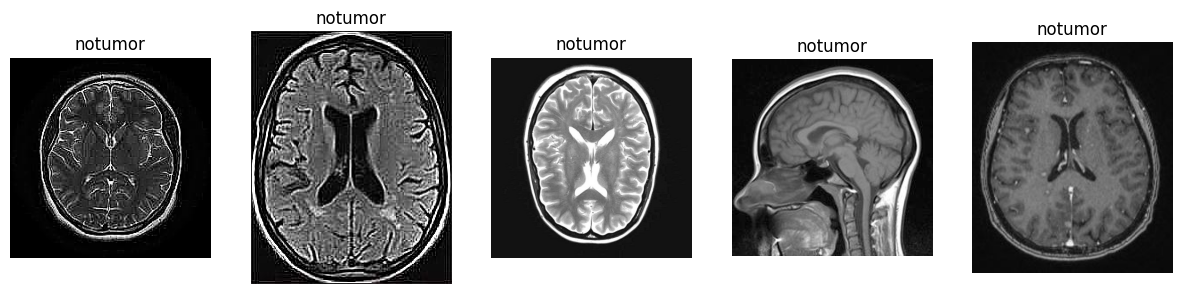

Class glioma: Displaying 5 images


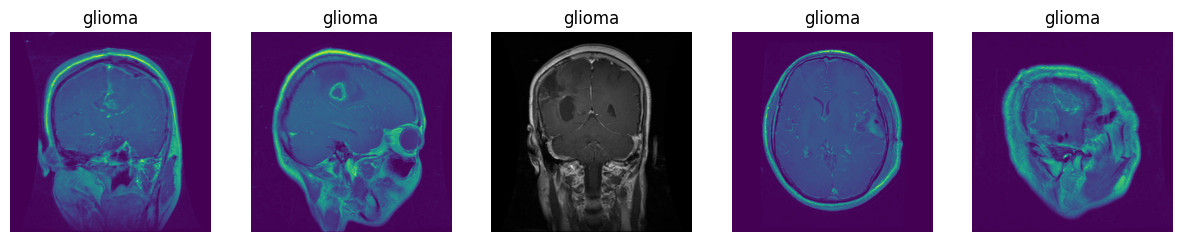

Class meningioma: Displaying 5 images


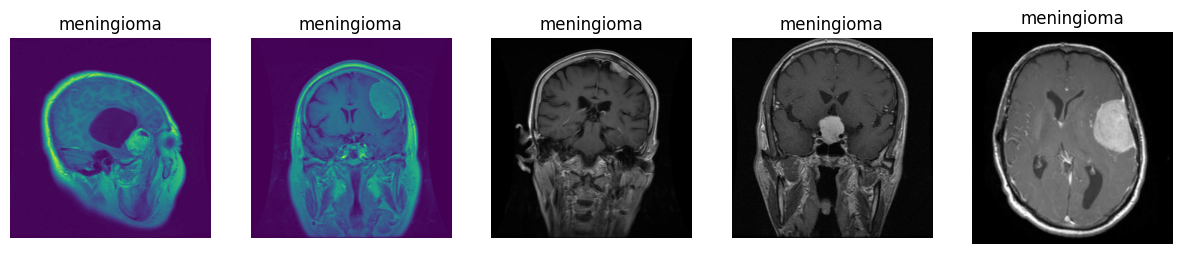

Class pituitary: Displaying 5 images


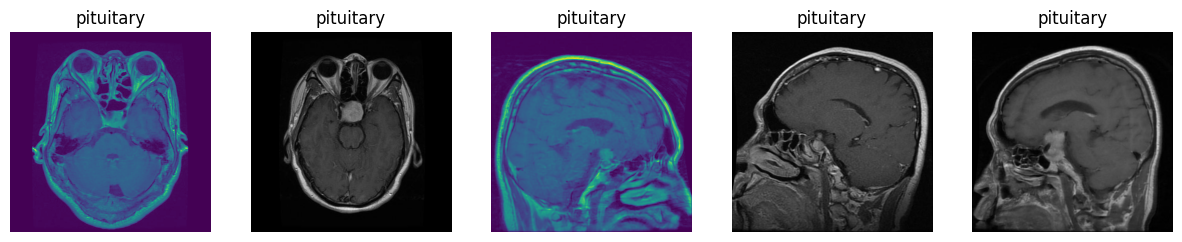

Testing Dataset:
Class notumor: Displaying 5 images


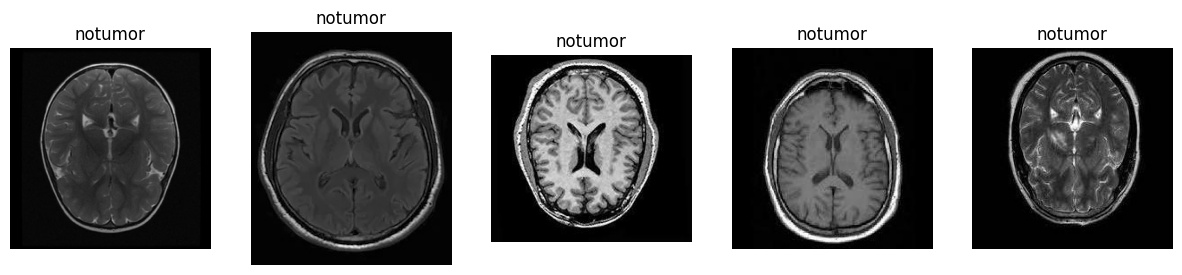

Class glioma: Displaying 5 images


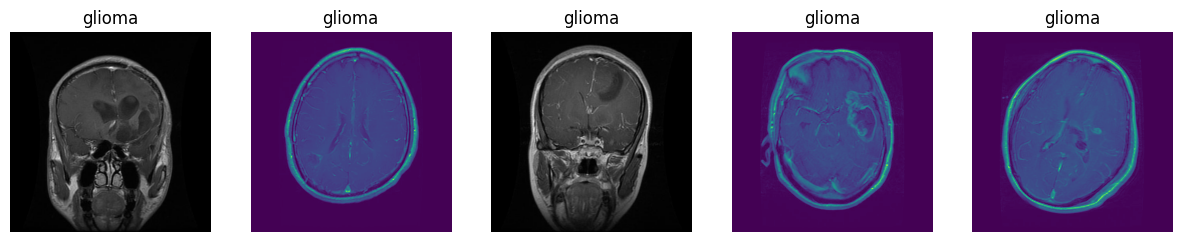

Class meningioma: Displaying 5 images


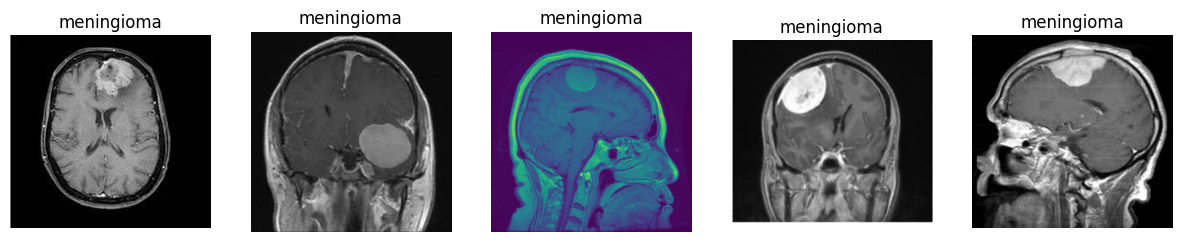

Class pituitary: Displaying 5 images


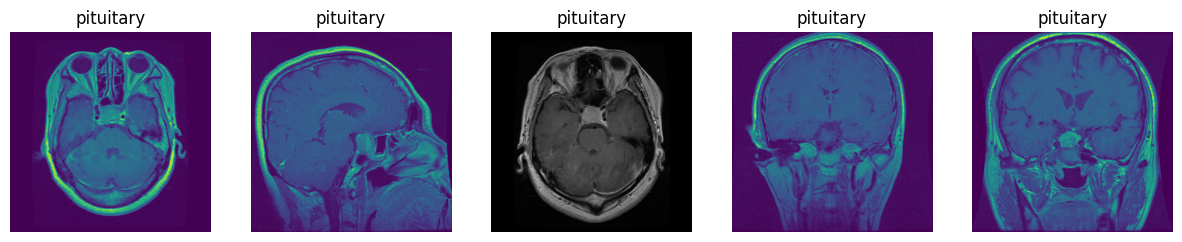

In [16]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_random_images(directory, num_images=5):
    classes = os.listdir(directory)

    for cls in classes:
        class_path = os.path.join(directory, cls)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            random_images = random.sample(images, min(num_images, len(images)))

            print(f'Class {cls}: Displaying {len(random_images)} images')
            fig, axes = plt.subplots(1, len(random_images), figsize=(15, 5))

            for ax, img_name in zip(axes, random_images):
                img_path = os.path.join(class_path, img_name)
                img = mpimg.imread(img_path)
                ax.imshow(img)
                ax.set_title(f'{cls}')
                ax.axis('off')

            plt.show()


print('Training Dataset:')
display_random_images(training_dir, num_images=5)

print('Testing Dataset:')
display_random_images(testing_dir, num_images=5)


In [17]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation


# Create datasets
batch_size = 32
image_dim = (256, 256)  # Assuming 256x256 images, modify as needed

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_dir,
    image_size=image_dim,
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='int'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testing_dir,
    image_size=image_dim,
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='int'
)

# Data augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and normalization
def preprocess_train(image, label):
    image = data_augmentation(image) / 255.0
    return image, label

# For test dataset only applying normalization
def preprocess_test(image, label):
    return image / 255.0, label

# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

# Classes and image shape: height, width, grayscale
num_classes = len(train_ds.class_names)
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

# Building model
model = Sequential([
    Input(shape=image_shape),
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# Compiling model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Custom callback for reducing learning rate at accuracy values
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds
        self.factor = factor
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

# Callbacks for improved convergence of gradient and best test accuracy
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc, lr_callback],
    verbose=True
)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Number of Classes: 4
Image shape: (256, 256, 1)
Epochs: 50
Batch size: 32
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 64)      1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 84, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
179/179 [==============================] - 39s 211ms/step - loss: 0.4792 - accuracy: 0.8174 - val_loss: 0.5074 - val_accuracy: 0.8040 - lr: 0.0010
Epoch 3/50
179/179 [==============================] - 38s 209ms/step - loss: 0.3324 - accuracy: 0.8789 - val_loss: 0.4759 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 4/50
179/179 [==============================] - 38s 212ms/step - loss: 0.2655 - accuracy: 0.9081 - val_loss: 0.3593 - val_accuracy: 0.8871 - lr: 0.0010
Epoch 5/50
179/179 [==============================] - 39s 216ms/step - loss: 0.1970 - accuracy: 0.9301 - val_loss: 0.2499 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 6/50
179/179 [==============================] - 38s 211ms/step - loss: 0.1527 - accuracy: 0.9454 - val_loss: 0.1924 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 7/50
179/179 [==============================] - 42s 230ms/step - loss: 0.1266 - accuracy: 0.9555 - val_loss: 0.2278 - val_accuracy: 0.9245 - lr: 0.0010
Epoch 8/50
179/179 [==============================] 

41/41 [==============================] - 1s 29ms/step - loss: 0.0309 - accuracy: 0.9962
Test Loss: 0.03094748966395855
Test Accuracy: 0.9961861371994019


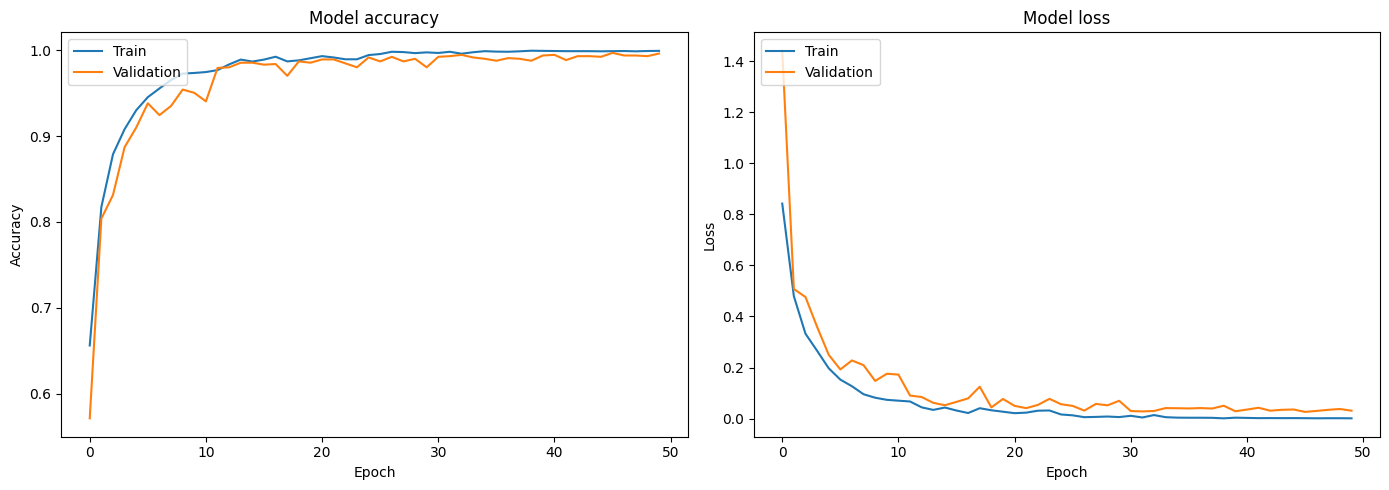

In [18]:
import matplotlib.pyplot as plt

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds_preprocessed)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 94ms/step
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       300
  meningioma       0.99      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



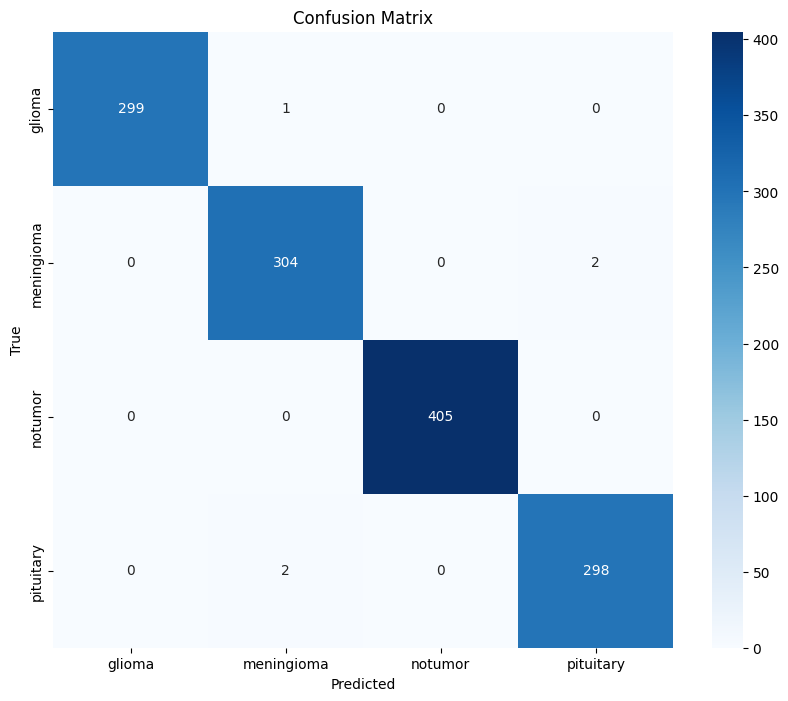

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Get the true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds_preprocessed:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to integer
    y_pred.extend(np.argmax(predictions, axis=1))  # Convert predictions to integer

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
class_names = train_ds.class_names
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
